# Spatial mapping to tranfer cell type labels, expression values, and spatial position

## Preliminaries

### Import packages & data

In [1]:
import matplotlib.pyplot as plt
import warnings
import scanpy as sc
import squidpy as sq
import anndata as ad
from harmony import harmonize
from cellmapper import CellMapper
import seaborn as sns

/cluster/project/treutlein/USERS/mlange/miniforge3/envs/cellmapper_gpu/lib/python3.12/importlib/__init__.py:90: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)
/cluster/project/treutlein/USERS/mlange/miniforge3/envs/cellmapper_gpu/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
sc.settings.set_figure_params(scanpy=True, frameon=False, fontsize=14)

Load the seqFISH data of XXX as a spatial query dataset and the scRNA-seq data of XXX as a dissociated ad_disserence dataset. Both profile mouse embryogenesis at approximately embryonic day (E) 8.5. 

In [3]:
ad_sp = sc.read("data/spatial.h5ad")
ad_sp

AnnData object with n_obs × n_vars = 51787 × 351
    obs: 'embryo', 'pos', 'z', 'embryo_pos', 'embryo_pos_z', 'Area', 'celltype_seqfish', 'sample_seqfish', 'umap_density_sample', 'modality', 'total_counts', 'n_counts', 'celltype_harmonized'
    var: 'gene_name'
    uns: 'celltype_harmonized_colors', 'celltype_seqfish_colors', 'embryo_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'X_umap_orig'
    varm: 'PCs'
    layers: 'counts', 'log_normalized'
    obsp: 'connectivities', 'distances'

In [4]:
ad_diss = sc.read("data/dissociated.h5ad")
ad_diss

AnnData object with n_obs × n_vars = 16496 × 18499
    obs: 'barcode', 'sample_rna', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype_rna', 'haem_subclust', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutDPT', 'endo_gutCluster', 'sizefactor', 'modality', 'total_counts', 'n_counts', 'celltype_harmonized'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_name'
    uns: 'celltype_harmonized_colors', 'celltype_rna_colors', 'cluster_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'sequencing.batch_colors', 'stage_colors', 'theiler_colors', 'umap'
    obsm: 'X_endo_gephi', 'X_endo_gut', 'X_haem_gephi', 'X_pca', 'X_umap', 'X_umap_orig'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

The spatial data contains all genes measured with seqFISH, the dissociated data contains all genes that passed basic filtering criteria. In both objects, `.X` corresponds to total counts normalized log1p transformed data, while raw counts are stored in `layers["counts"]`. We manually harmonized cell type annotations (stored in `.obs["celltype_harmonized"]` in either object), following ENVI (CITE). 

### Update both AnnData objects

Fix gene names

In [5]:
ad_diss.var.set_index("gene_name", inplace=True)
ad_sp.var.set_index("gene_name", inplace=True)

Rename the `.obsm` field where spatial data is stored. 

In [7]:
ad_sp.obsm["spatial"] = ad_sp.obsm["X_spatial"].copy()
del ad_sp.obsm["X_spatial"]

Flip coordinates

In [8]:
ad_sp.obsm["spatial"][:, 1] = ad_sp.obsm["spatial"][:, 1] * -1

### Basic visualization

Let's take a closer look at these two datasets before we get started. For the seqFISH data, we can visualize harmonized cell type labels in space. 

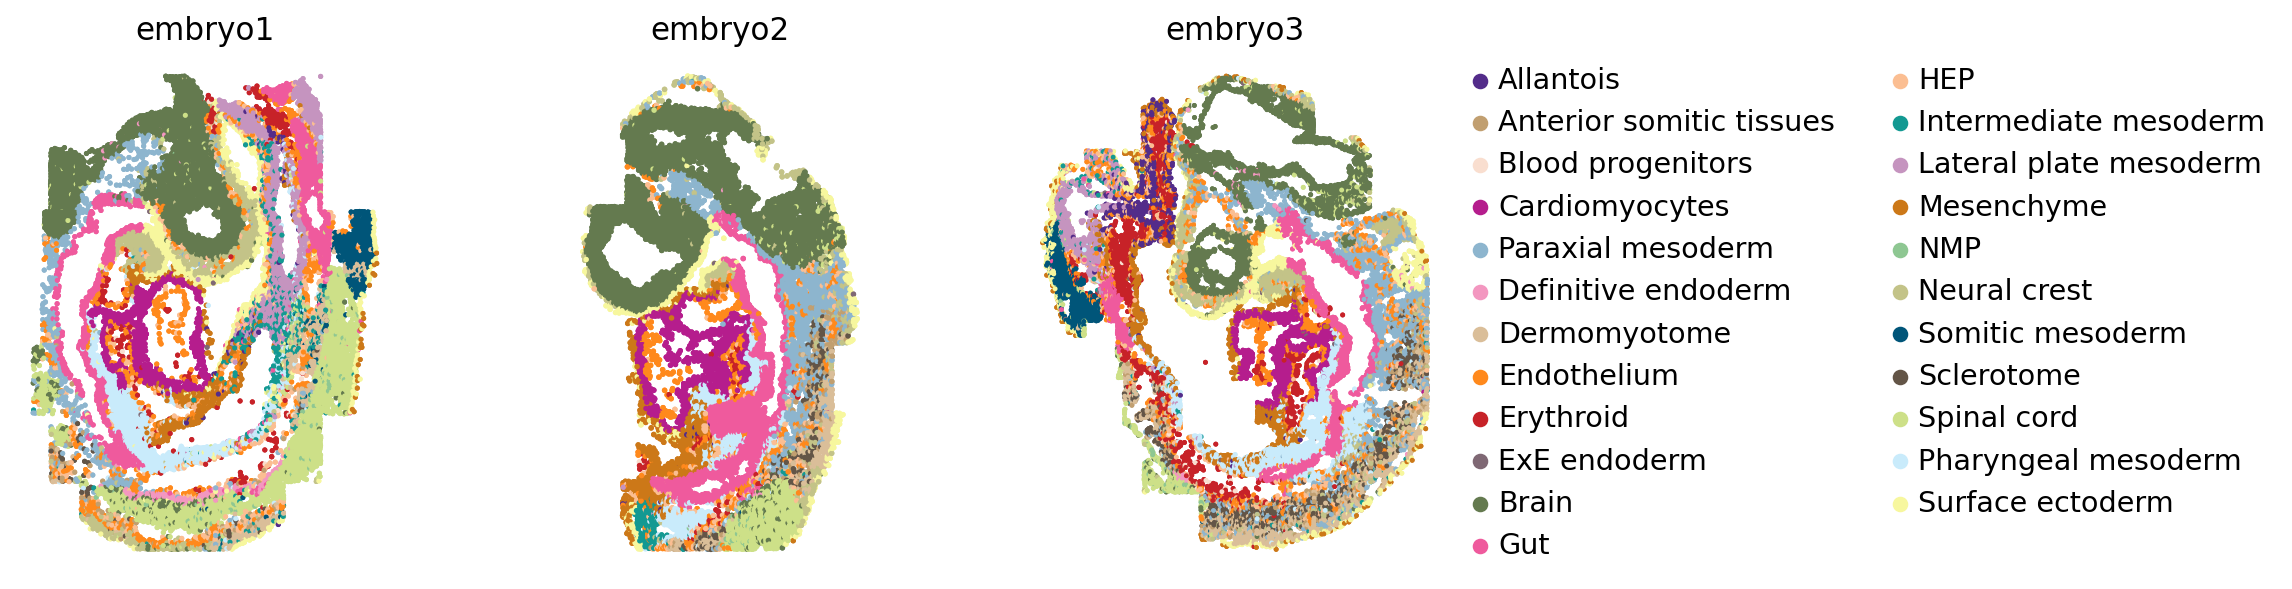

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    keys = ad_sp.obs["embryo"].cat.categories

    _, axes = plt.subplots(1, len(keys), figsize=(len(keys) * 4 + 4, 4))

    for i, (ax, cat) in enumerate(zip(axes, keys, strict=True)):
        obs_mask = ad_sp.obs["embryo"] == cat
        sq.pl.spatial_scatter(
            ad_sp[obs_mask],
            ax=ax,
            color="celltype_harmonized",
            title=cat,
            shape=None,
            library_id=None,
            legend_loc="right margin" if i == len(keys) - 1 else "none",
        )

    plt.tight_layout()

For the dissociated data, we can show a simple UMAP. 

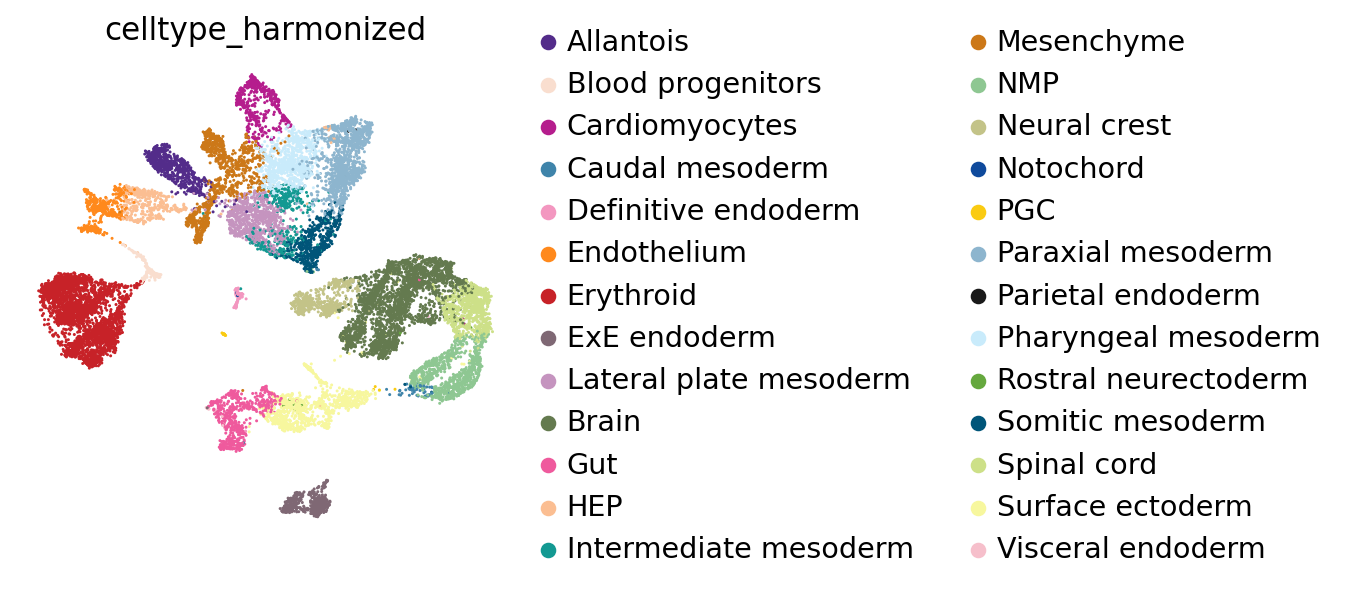

In [10]:
sc.pl.embedding(ad_diss, basis="X_umap", color="celltype_harmonized")

### Compute a joint embedding

Everything we do in `CellMapper` is based on a joint embedding between query (spatial) and reference (dissociated) data. For simplicity, we will compute such a joint embedding here with Harmony (CITE). 

In [11]:
# Harmony expects a combined AnnData object and a joint PCA
ad_combined = ad.concat([ad_sp, ad_diss], join="inner", axis=0, label="modality", keys=["spatial", "dissociated"])

# compute a PCA on overlapping genes
ad_combined.X = ad_combined.layers["counts"].copy()
sc.pp.normalize_total(ad_combined, target_sum=1e4)
sc.pp.log1p(ad_combined)
sc.pp.pca(ad_combined)

# run Harmony, place the joint embedding in the obsm slot
ad_combined.obsm["X_harmony"] = harmonize(ad_combined.obsm["X_pca"], ad_combined.obs, batch_key="modality")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
Reach convergence after 9 iteration(s).


For visualization, compute UMAPs in the joint PCA and integrated harmony latent spaces. 

In [12]:
# joint PCA space
sc.pp.neighbors(ad_combined, use_rep="X_pca")
sc.tl.umap(ad_combined, key_added="X_umap_pca")

# integrated harmony space
sc.pp.neighbors(ad_combined, use_rep="X_harmony")
sc.tl.umap(ad_combined, key_added="X_umap_harmony")

/cluster/project/treutlein/USERS/mlange/miniforge3/envs/cellmapper_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Visualize both with UMAP

Simple PCA on overlapping genes


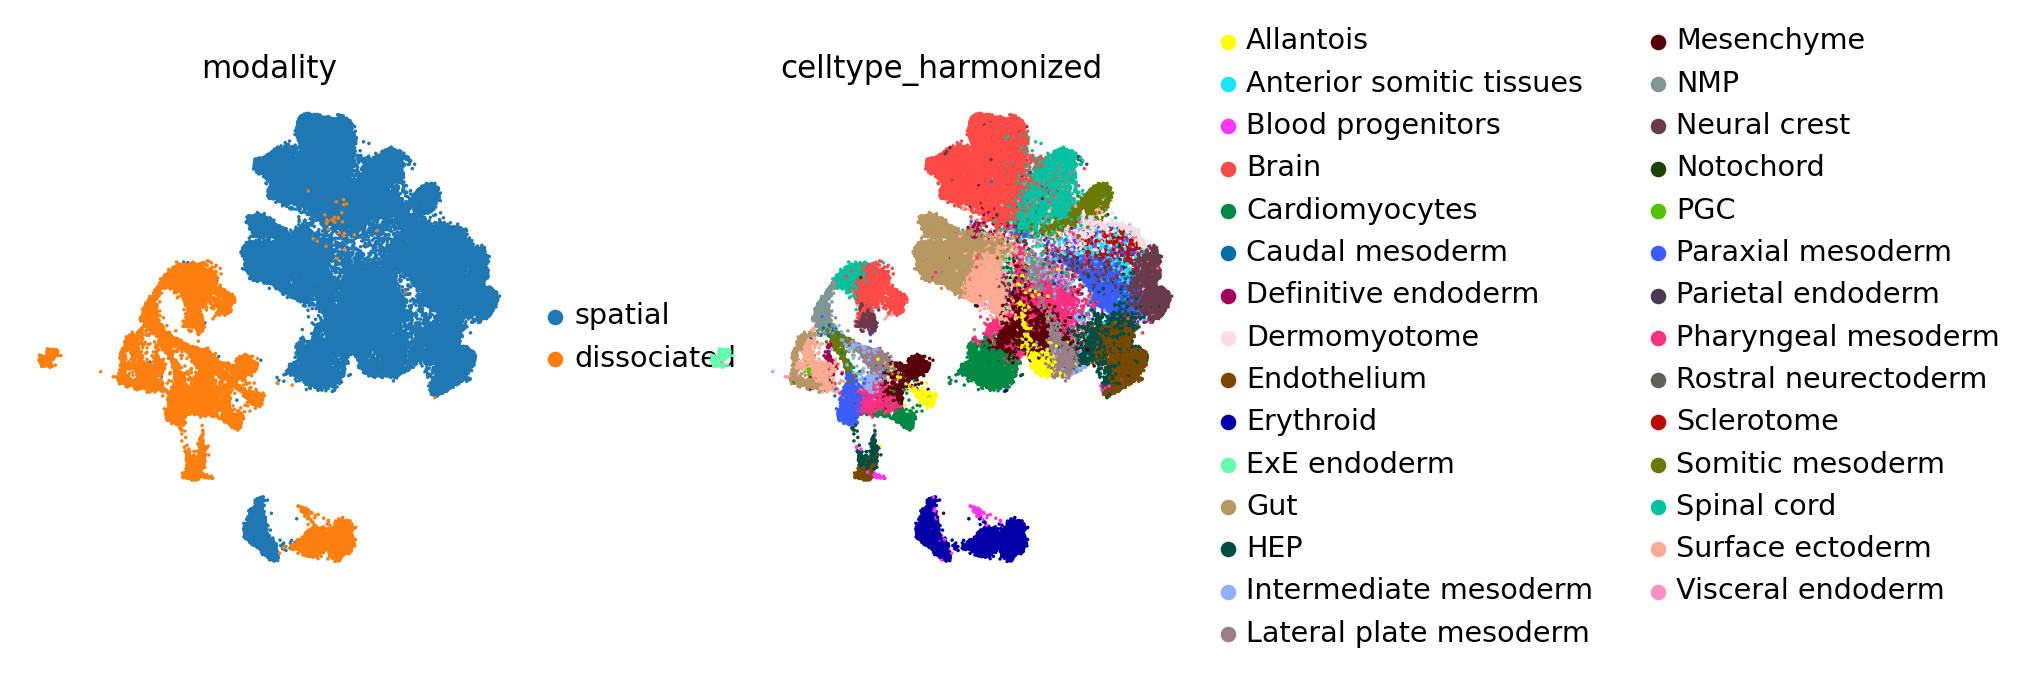

Harmony integrated latent space


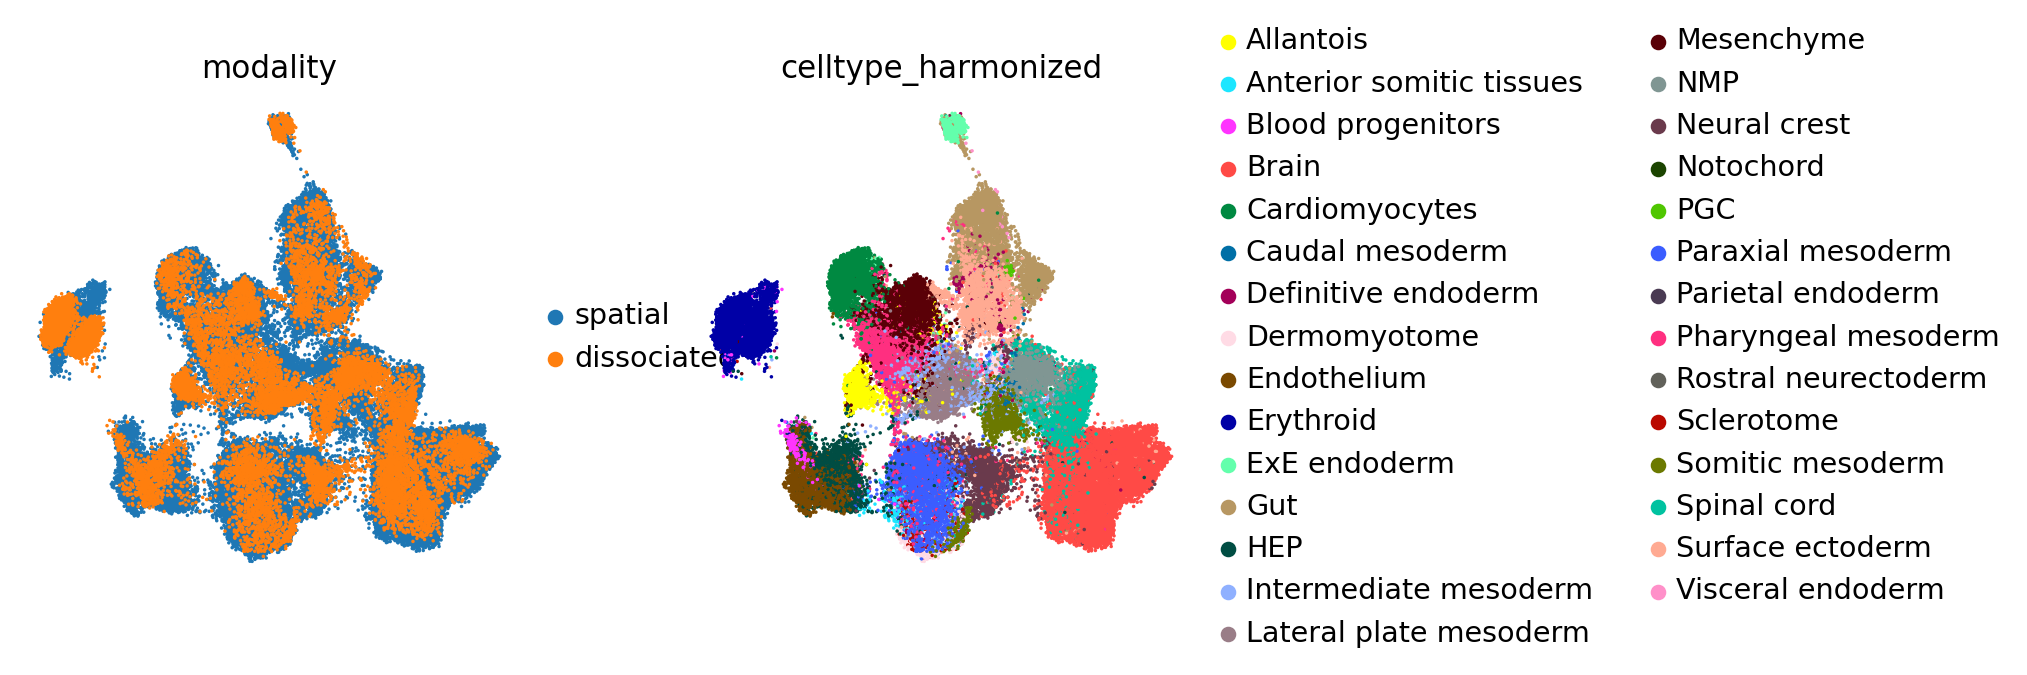

In [13]:
print("Simple PCA on overlapping genes")
sc.pl.embedding(
    ad_combined,
    basis="X_umap_pca",
    color=[
        "modality",
        "celltype_harmonized",
    ],
    legend_loc="right margin",
    size=10,
)

print("Harmony integrated latent space")
sc.pl.embedding(
    ad_combined,
    basis="X_umap_harmony",
    color=[
        "modality",
        "celltype_harmonized",
    ],
    legend_loc="right margin",
    size=10,
)

Looks like Harmony aligned both datasets - to make this statement robust and quantitative, we should compute some metrics, like scIB metrics (CITE), but for the purpose of this tutorial, let's just work with this Harmony latent space. We will copy it back into the individual AnnData objects. 

In [15]:
ad_diss.obsm["X_harmony"] = ad_combined[ad_combined.obs["modality"] == "dissociated"].obsm["X_harmony"].copy()
ad_sp.obsm["X_harmony"] = ad_combined[ad_combined.obs["modality"] == "spatial"].obsm["X_harmony"].copy()

## Work with CellMapper

### Initialize and compute the mapping matrix

In [16]:
cmap = CellMapper(ref=ad_diss, query=ad_sp)
cmap

CellMapper(ref=AnnData(n_obs=16,496, n_vars=18,499), query=AnnData(n_obs=51,787, n_vars=351), n_neighbors=None, prediction_postfix=None, confidence_postfix=None)

The central object in CellMapper is the `mapping_matrix`, which we will use throughout all use cases below. 

In [17]:
cmap.compute_neighbors(use_rep="X_harmony", only_yx=True)
cmap.compute_mappping_matrix()

INFO     Using sklearn to compute 30 neighbors.                                                                    
INFO     Computing mapping matrix using method 'gaussian'.                                                         
INFO     Row-normalizing the mapping matrix.                                                                       


## Transfer labels

Let's pretend we don't have cell type annotations in the spatial data and we want to transfer them from the dissociated data. 

In [18]:
cmap.transfer_labels(obs_keys="celltype_harmonized")

INFO     Predicting labels for key 'celltype_harmonized'.                                                          
INFO     Labels transferred and stored in query.obs['celltype_harmonized_pred'].                                   


Let's take a look at original and predicted cell type labels for the spatial query data. We'll take `embryo1` as an example. 

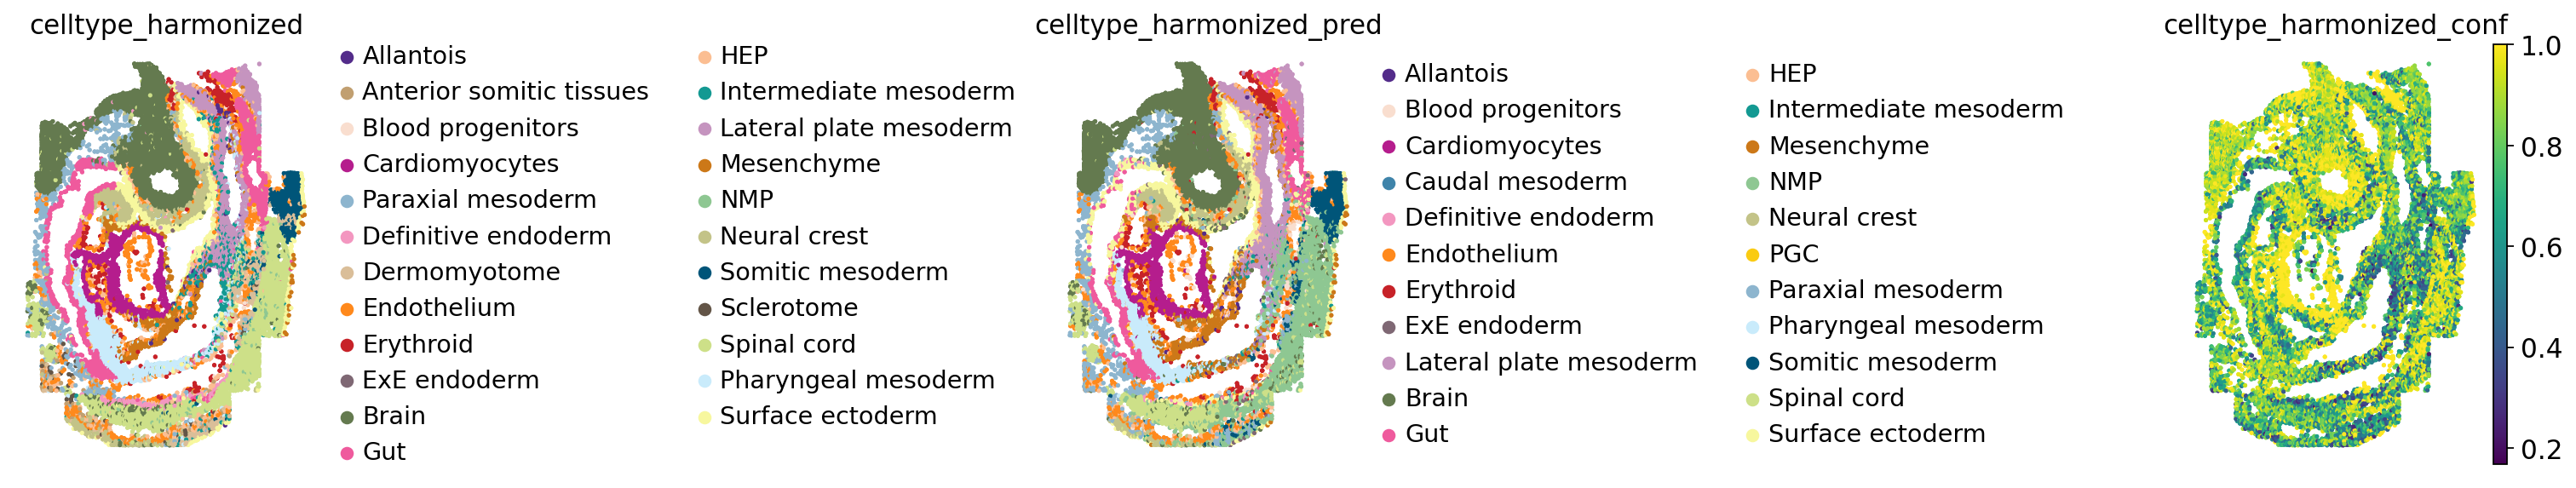

In [19]:
obs_mask = ad_sp.obs["embryo"] == "embryo1"

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sq.pl.spatial_scatter(
        ad_sp[obs_mask],
        color=["celltype_harmonized", "celltype_harmonized_pred", "celltype_harmonized_conf"],
        shape=None,
        wspace=1.0,
    )

For most cell types, this looks okay. Confidence scores are written to `.obs` let's take a look at their distribution: 

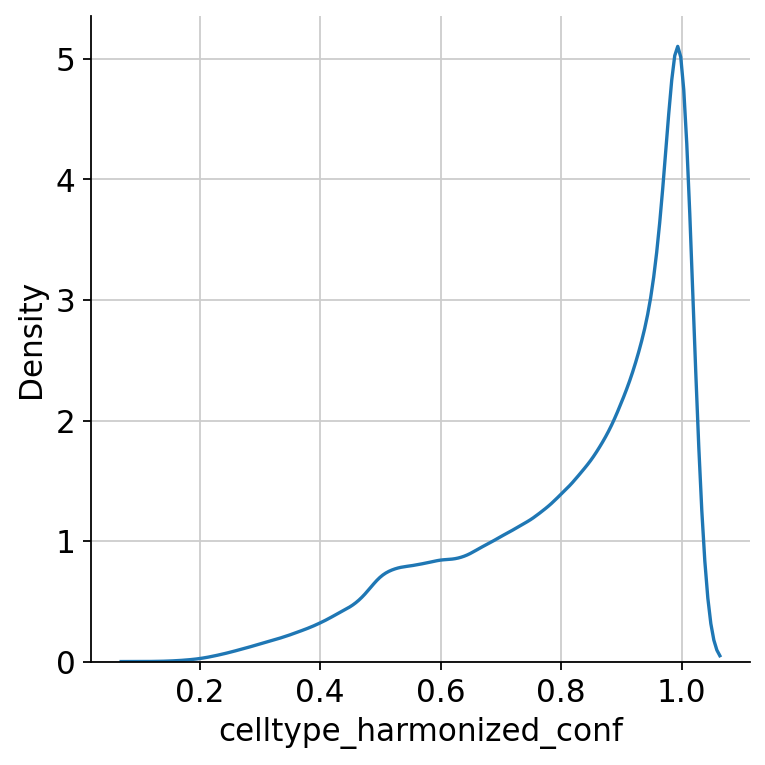

In [20]:
sns.displot(ad_sp.obs["celltype_harmonized_conf"], kind="kde")

To focus on high-confidence predictions, we could now threshold based on this score. To gain more insights into the mapping on the cell type level, let's look at a confusion matrix. 

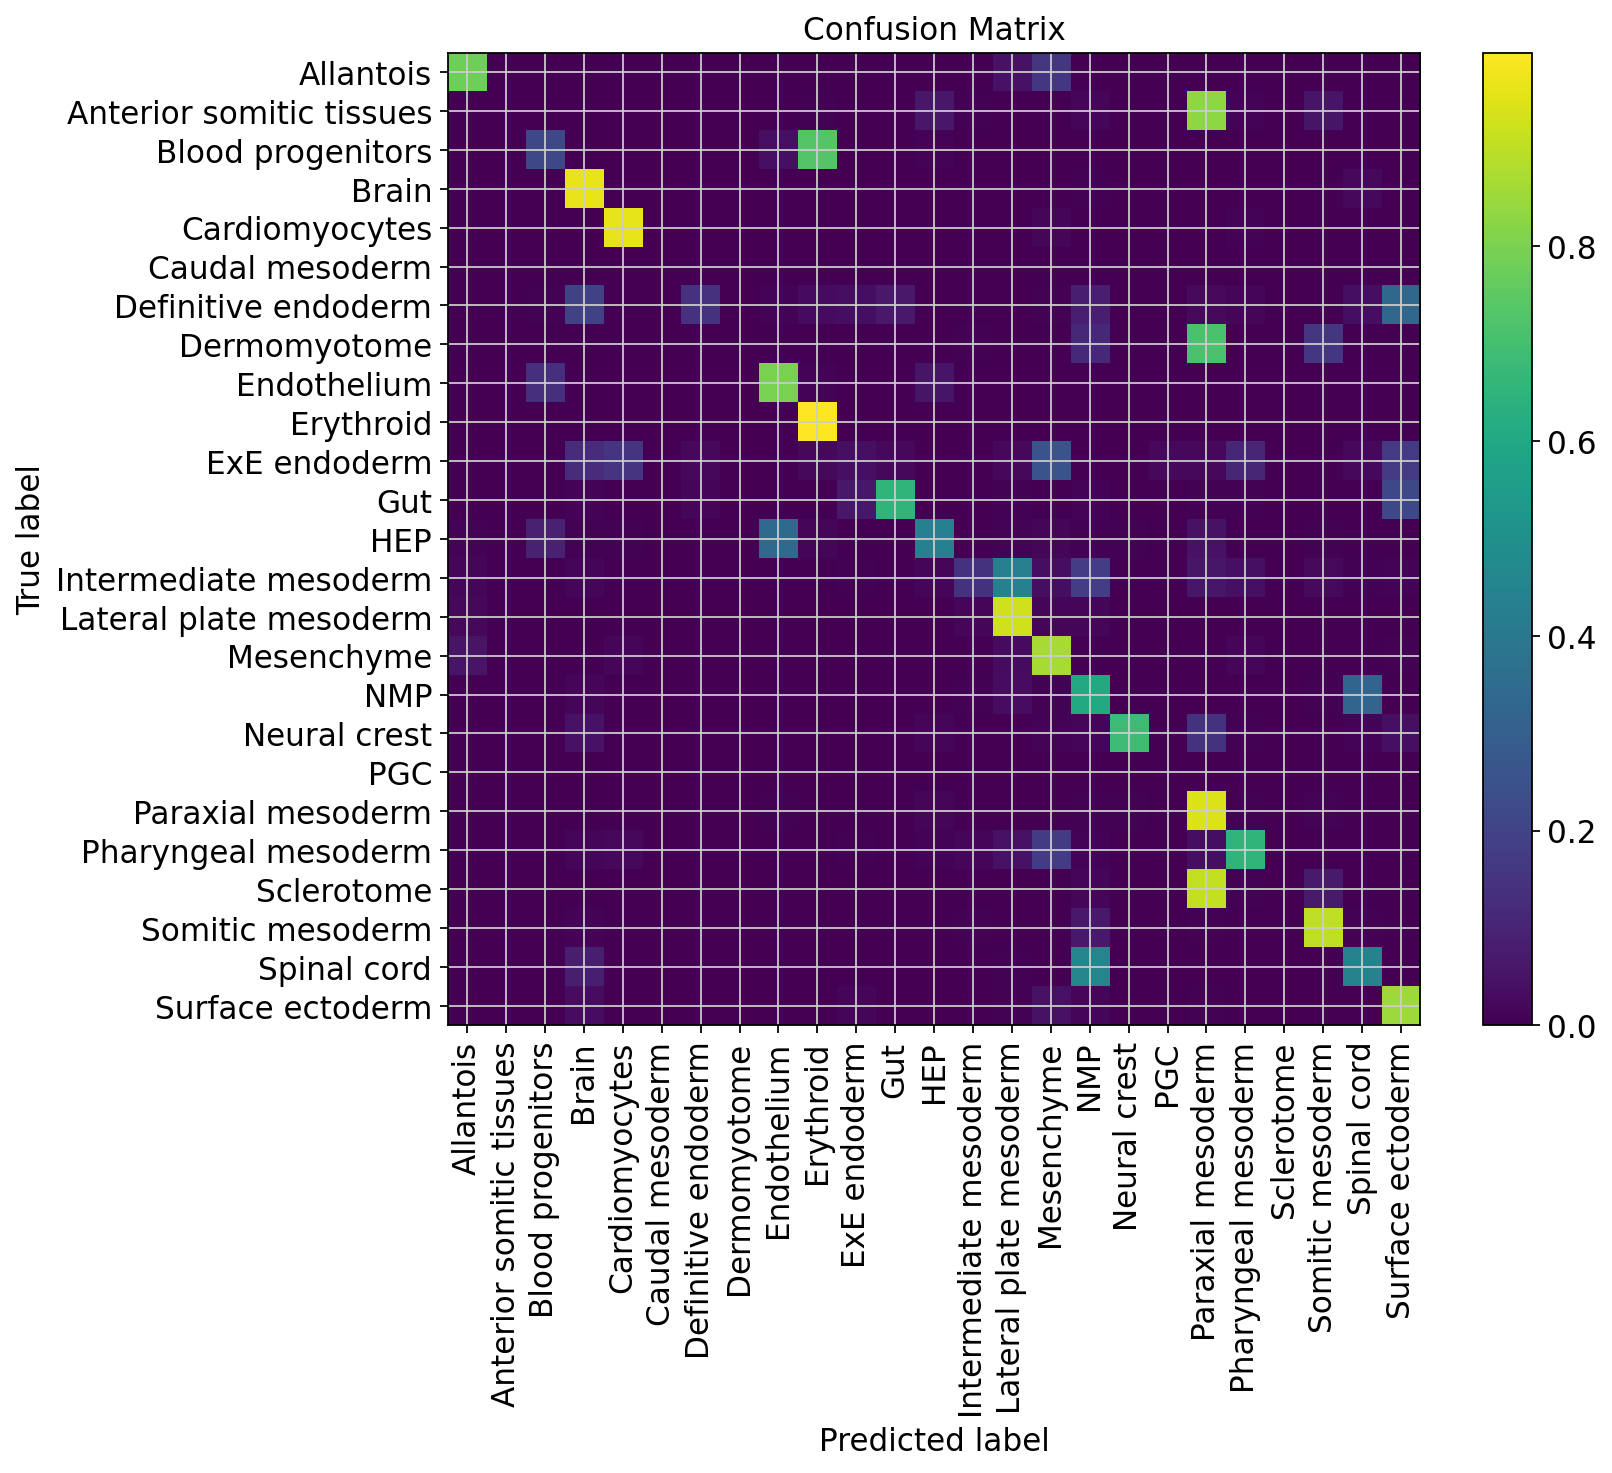

In [21]:
cmap.plot_confusion_matrix(label_key="celltype_harmonized", include_values=False, normalize="true")

Except for a couple of outliers, some of which map to related tissues, this looks quite good. Let's quantify this next. For this evaluation, we can threshold based on the confidence score from above. 

In [22]:
cmap.evaluate_label_transfer("celltype_harmonized", confidence_cutoff=0.4)

INFO     Accuracy: 0.7355, Precision: 0.7625, Recall: 0.7355, Weighted F1-Score: 0.7261, Macro F1-Score: 0.5311,   
         Excluded Fraction: 0.0303                                                                                 


A weighted f1 score of 0.72 on this dataset is pretty good, given that the abundance of certain cell types varies strongly between spatial and dissociated data: 

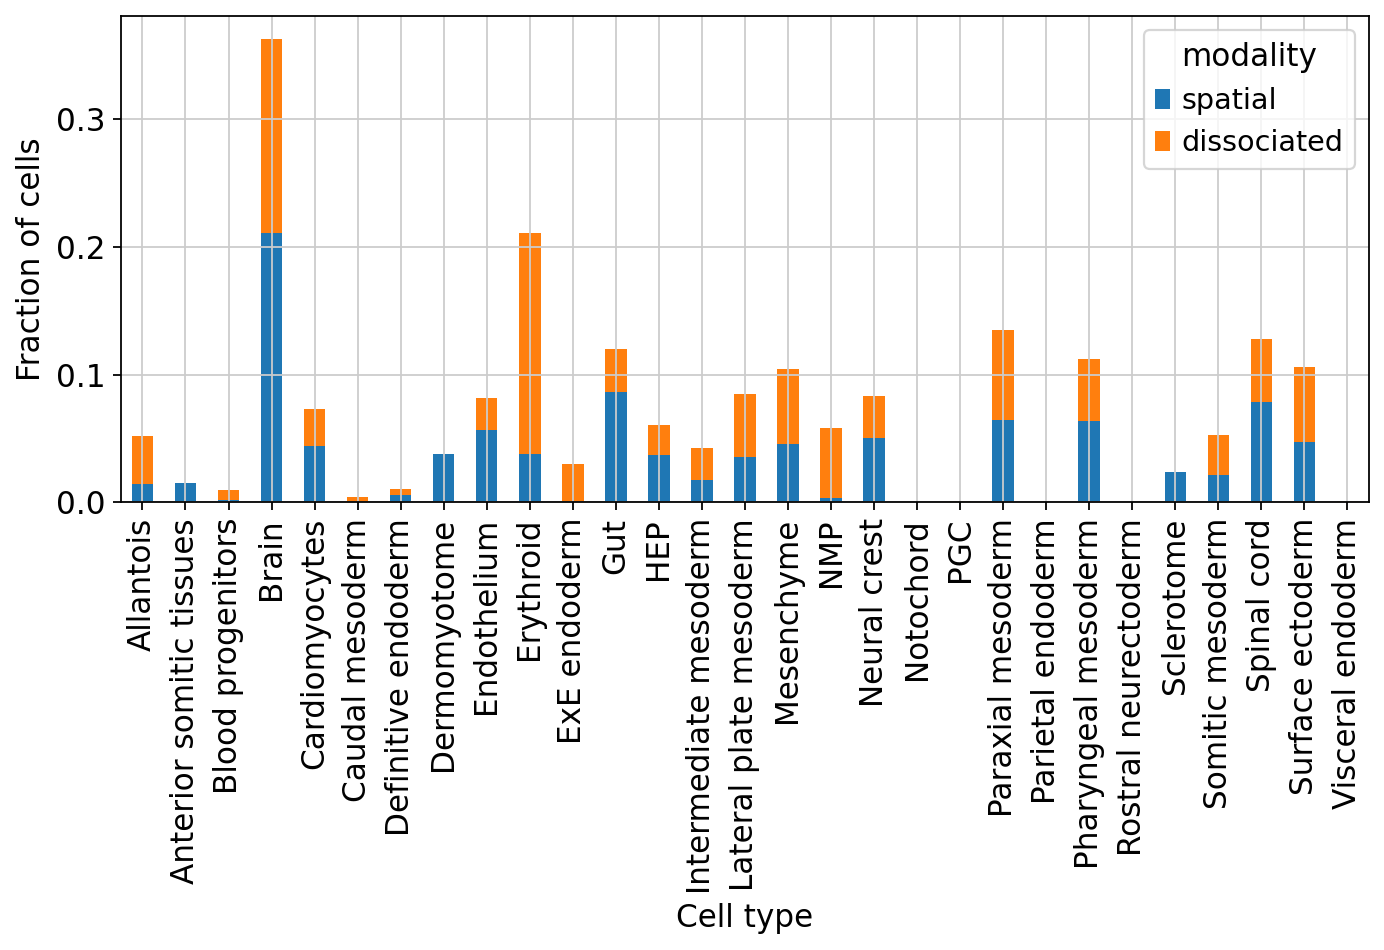

In [23]:
df = ad_combined.obs.groupby(["celltype_harmonized", "modality"], observed=False).size().unstack()
df /= df.sum(0)
ax = df.plot(kind="bar", stacked=True, figsize=(10, 4))

ax.set_ylabel("Fraction of cells")
ax.set_xlabel("Cell type")

plt.show()

### Transfer expression

We have many more genes measured in the dissociated dataset, so let's impute their expression in space.

In [24]:
cmap.transfer_expression(layer_key="X")

INFO     Transferring layer for key 'X'.                                                                           
INFO     Imputed expression for layer 'X' stored in self.query_imputed.X.                                          
         Note: The feature space now matches the reference (n_vars=18499), not the query (n_vars=351).             


Let's visualize imputed (written to `.query_imputed`) and original gene expression here. Note that for a proper comparison, we would have to hold out some genes. We're using `embryo1` as an example. 

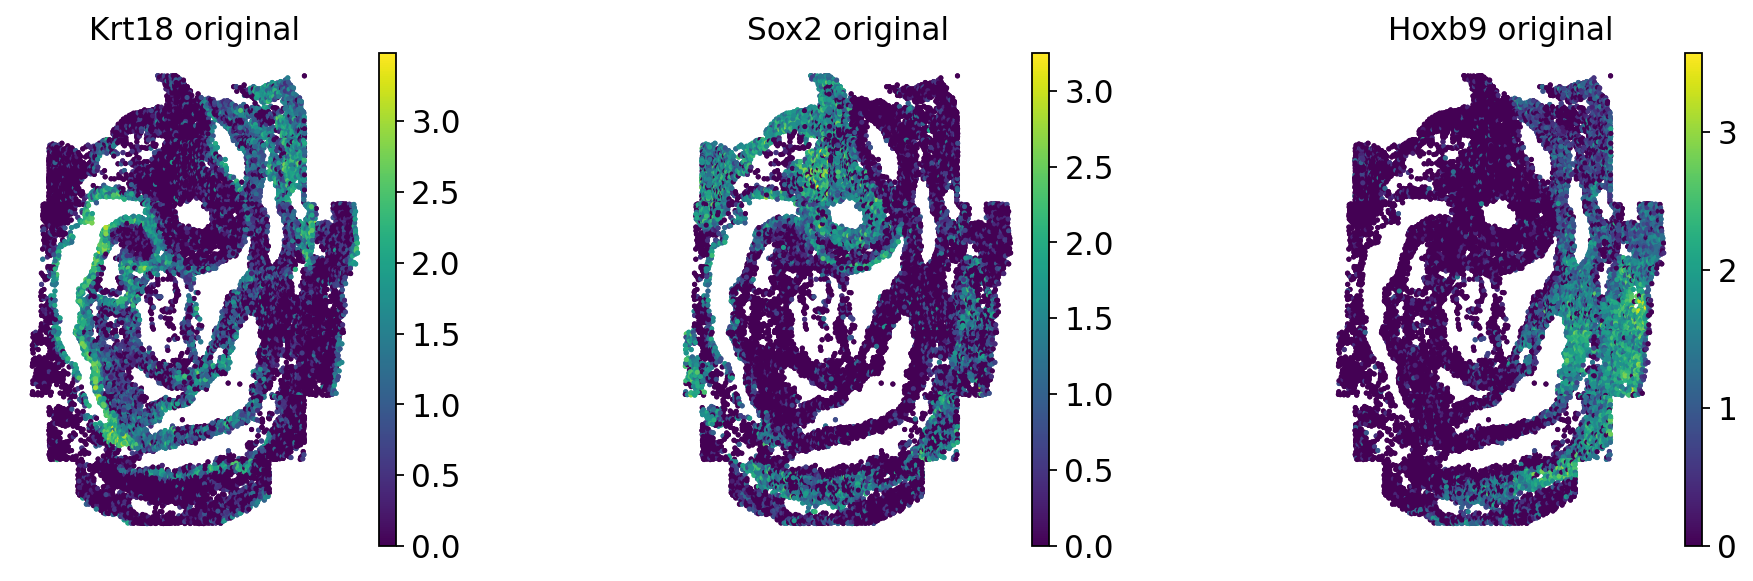

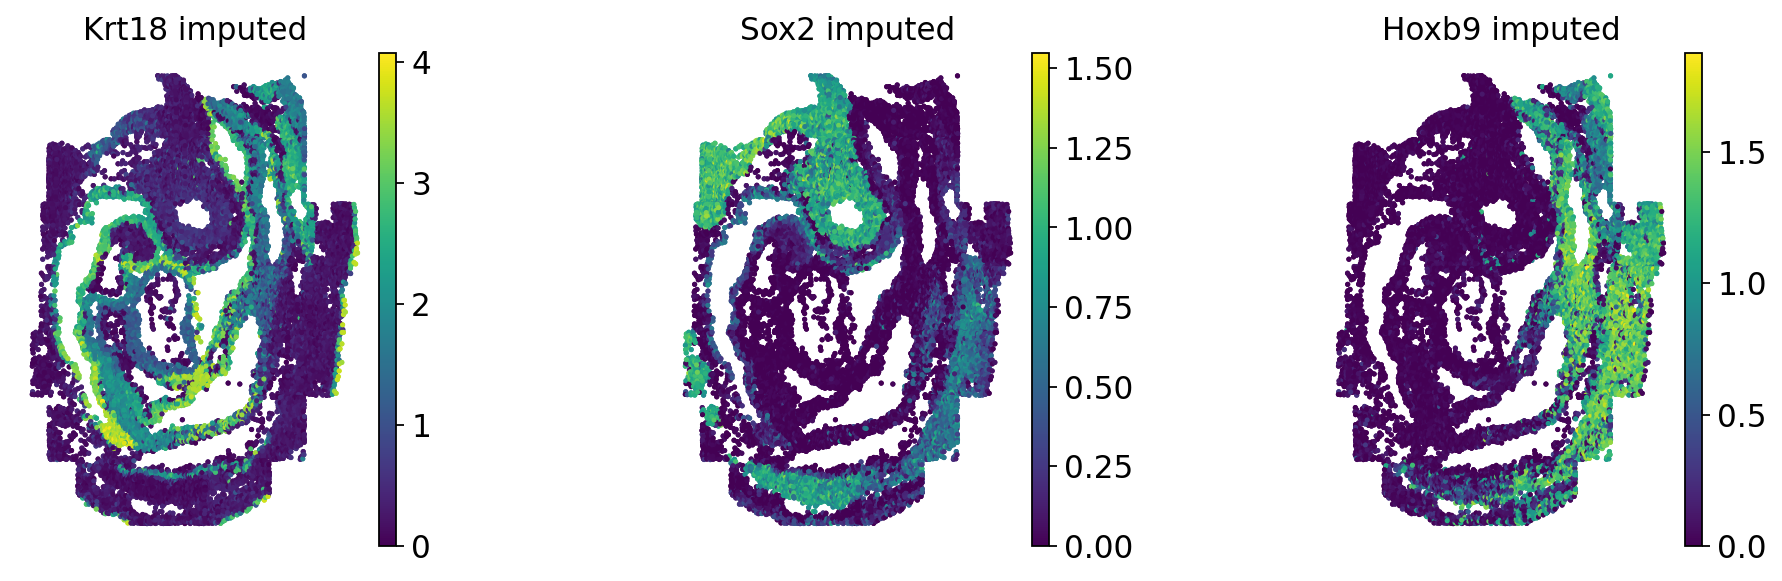

In [33]:
obs_mask = ad_sp.obs["embryo"] == "embryo1"
genes = ["Krt18", "Sox2", "Hoxb9"]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sq.pl.spatial_scatter(ad_sp[obs_mask], color=genes, shape=None, title=[f"{x} original" for x in genes])
    sq.pl.spatial_scatter(cmap.query_imputed[obs_mask], color=genes, shape=None, title=[f"{x} imputed" for x in genes])

We can quantify this through correlation. Let's stratify by `embryo`, to see whether there are differences in performance. 

In [49]:
cmap.evaluate_expression_transfer(layer_key="X", groupby="embryo")

INFO     Expression transfer evaluation (pearson): average value = 0.3359 (n_genes=350, n_valid_genes=350)         
INFO     Metrics per group defined in `query.obs['embryo']` computed and stored in `query.varm['metric_pearson']`  


Across all overlapping genes, and all cells, we get an average correlation of 0.33, which is quite good, however, we're overfitting this data as we did not hold out any genes, so interpret this value with caution. Let's compare this across embryos. 

In [50]:
ad_sp.varm["metric_pearson"].mean()

embryo1    0.300269
embryo2    0.339218
embryo3    0.340851
dtype: float32

It looks like there are some differences, and imputation worked best for `embryo3`. CellMapper supports further metrics to compare transferred exrpression, such as spearman correlation or Jensen–Shannon divergence. 